# **Statistics tutorial**
In this Jupyter tutorial we will show some examples of how to extract statistics from our data. These methods are implemented as part of the functionality of PyOskar API using the _transformers_ Spark model. These kind of functions depend directly from an _Oskar()_ object, and they will return a whole dataframe with the due transformation applied.
> <span style="color:#ff6600">**In order to optimise the performance we decided to integrate PyOskar in PySpark default API. This means that it is possible to manage data simultaneously with functions from both libraries in case we want to select specific fields, visualize the dataframe, filter the output or performing other operations besides PyOskar API.**</span>

First, we need to import the PyOskar and PySpark modules. Second, we need to create an instance of the _Oskar()_ object, from which depends a big part of the functionality. Finally, we must use the _load()_ function pointing to where the parquet file is stored to convert our data into a DataFrame _df_, and we are ready to start playing.

In [2]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("./data/platinum_chr22.small.parquet")

You can use PySpark _show()_ method to print the data from _df_. This is how our testing dataframe looks like. As you can see for this tutorial we have selected a small dataset from Illumina Platinum Genomes with 1,000 random variants from chromosome 22, which pertain to a set of 17 samples.

In [2]:
print("Print first 20 variants:")
df.show()

Print first 20 variants:
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length| type|hgvs|             studies|          annotation|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|22:16054454:C:T|   []|        22|16054454|16054454|        C|        T|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16054454, 16...|
|22:16065809:T:C|   []|        22|16065809|16065809|        T|        C|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16065809, 16...|
|22:16077310:T:A|   []|        22|16077310|16077310|        T|        A|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16077310, 16...|
|22:16080499:A:G|   []|        22|16080499|16080499|        A|        G|     +|null|     1|  SNV|  []|[[h

NOTE: With _df.printSchema()_ command you can check the dataset hierarchy and all its fields.

In [4]:
print("Samples:")
oskar.metadata.samples(df)

Samples:


{'hgvauser@platinum:illumina_platinum': ['NA12877',
  'NA12878',
  'NA12879',
  'NA12880',
  'NA12881',
  'NA12882',
  'NA12883',
  'NA12884',
  'NA12885',
  'NA12886',
  'NA12887',
  'NA12888',
  'NA12889',
  'NA12890',
  'NA12891',
  'NA12892',
  'NA12893']}

In [3]:
print("Total number of variants:")
df.count()

Total number of variants:


1000

## Stats per variant
Here we present the genotypes of the variants from which the later stats will come out:

In [2]:
df.select(df.id, df.studies.samplesData.alias("genotypes")).show(10, truncate = False)

+---------------+-------------------------------------------------------------------------------------------------------------------------+
|id             |genotypes                                                                                                                |
+---------------+-------------------------------------------------------------------------------------------------------------------------+
|22:16054454:C:T|[[[./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [./.], [./.], [./.]]]|
|22:16065809:T:C|[[[0/1], [./.], [./.], [./.], [0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [0/1]]]|
|22:16077310:T:A|[[[./.], [0/1], [0/1], [./.], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [./.], [0/1], [./.], [./.]]]|
|22:16080499:A:G|[[[0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [./.]]]|
|22:16084621:T:C|[[[

In this case we are applying a transformation that adds new data inside the _stats_ field, which is empty before we do anything:

In [9]:
df.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq")\
    .show(10, truncate = False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|null       |null          |null          |null              |null                |null         |null         |
|22:16065809:T:C|null       |null          |null          |null              |null                |null         |null         |
|22:16077310:T:A|null       |null          |null          |null              |null                |null         |null         |
|22:16080499:A:G|null       |null          |null          |null              |null                |null         |null         |
|22:16084621:T:C|null       |null          |null          |null              |null                |null 

Now we proceed to call the _stats()_ transformer through our _oskar_ instance. That means that our dataframe will go through some kind of operation. It is important to know how transformers work in order to correctly access the new information.
<br>
Usage:
```python
stats(df[DataFrame], studyId[str]=None, cohort[str]=None, samples[str]=None, missingAsReference[bool]=None)
```

In [15]:
statsDF = oskar.stats(df)
statsDF.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq")\
    .show(10, truncate = False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|2          |1             |1             |32                |16                  |0.5          |0.5          |
|22:16065809:T:C|12         |6             |6             |22                |11                  |0.5          |0.5          |
|22:16077310:T:A|14         |7             |7             |20                |10                  |0.5          |0.5          |
|22:16080499:A:G|8          |4             |4             |26                |13                  |0.5          |0.5          |
|22:16084621:T:C|10         |5             |5             |24                |12                  |0.5  

Since our data has some empty genotypes, we would like to treat those missing values as if they were the reference. For that issue we dispose of _missingAsReference_ parameter:

In [6]:
missingAsReferenceStatsDF = oskar.stats(df, missingAsReference = True)
missingAsReferenceStatsDF.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq")\
    .show(10, truncate = False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|34         |33            |1             |0                 |0                   |0.9705882    |0.029411765  |
|22:16065809:T:C|34         |28            |6             |0                 |0                   |0.8235294    |0.1764706    |
|22:16077310:T:A|34         |27            |7             |0                 |0                   |0.7941176    |0.20588236   |
|22:16080499:A:G|34         |30            |4             |0                 |0                   |0.88235295   |0.11764706   |
|22:16084621:T:C|34         |29            |5             |0                 |0                   |0.852

Other statistics that our method provides are the next ones:

In [20]:
oskar.stats(df, missingAsReference = True).selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "genotypeCount", "genotypeFreq", "mafAllele", "maf", "mgfGenotype", "mgf").show(10, truncate = False)

+---------------+---------------------+-------------------------------------------------+---------+-----------+-----------+---+
|id             |genotypeCount        |genotypeFreq                                     |mafAllele|maf        |mgfGenotype|mgf|
+---------------+---------------------+-------------------------------------------------+---------+-----------+-----------+---+
|22:16054454:C:T|[0/0 -> 16, 0/1 -> 1]|[0/0 -> 0.9411765, 0/1 -> 0.05882353, 1/1 -> 0.0]|T        |0.029411765|1/1        |0.0|
|22:16065809:T:C|[0/0 -> 11, 0/1 -> 6]|[0/0 -> 0.64705884, 0/1 -> 0.3529412, 1/1 -> 0.0]|C        |0.1764706  |1/1        |0.0|
|22:16077310:T:A|[0/0 -> 10, 0/1 -> 7]|[0/0 -> 0.5882353, 0/1 -> 0.4117647, 1/1 -> 0.0] |A        |0.20588236 |1/1        |0.0|
|22:16080499:A:G|[0/0 -> 13, 0/1 -> 4]|[0/0 -> 0.7647059, 0/1 -> 0.23529412, 1/1 -> 0.0]|G        |0.11764706 |1/1        |0.0|
|22:16084621:T:C|[0/0 -> 12, 0/1 -> 5]|[0/0 -> 0.7058824, 0/1 -> 0.29411766, 1/1 -> 0.0]|C        |0.147

There are other options we could execute:
 - Getting stats from specific individuals. In that case we need to provide a list of samples.
 - Specify the name we want to give to the stats cohort, which by default is "ALL".

In [30]:
samples = oskar.metadata.samples(df)["hgvauser@platinum:illumina_platinum"]
tenSamples = list(samples[0:10])
oskar.stats(df, studyId = "hgvauser@platinum:illumina_platinum", cohort = "Caucasians", samples = tenSamples, missingAsReference = True)\
    .selectExpr("id", "studies[0].stats.Caucasians as stats").select("id", "stats.*")\
    .select("id", "genotypeCount", "genotypeFreq", "mafAllele", "maf", "mgfGenotype", "mgf").show(10, truncate = False)

+---------------+--------------------+------------------------------------+---------+----+-----------+---+
|id             |genotypeCount       |genotypeFreq                        |mafAllele|maf |mgfGenotype|mgf|
+---------------+--------------------+------------------------------------+---------+----+-----------+---+
|22:16054454:C:T|[0/0 -> 10]         |[0/0 -> 1.0, 0/1 -> 0.0, 1/1 -> 0.0]|T        |0.0 |0/1        |0.0|
|22:16065809:T:C|[0/0 -> 7, 0/1 -> 3]|[0/0 -> 0.7, 0/1 -> 0.3, 1/1 -> 0.0]|C        |0.15|1/1        |0.0|
|22:16077310:T:A|[0/0 -> 5, 0/1 -> 5]|[0/0 -> 0.5, 0/1 -> 0.5, 1/1 -> 0.0]|A        |0.25|1/1        |0.0|
|22:16080499:A:G|[0/0 -> 8, 0/1 -> 2]|[0/0 -> 0.8, 0/1 -> 0.2, 1/1 -> 0.0]|G        |0.1 |1/1        |0.0|
|22:16084621:T:C|[0/0 -> 7, 0/1 -> 3]|[0/0 -> 0.7, 0/1 -> 0.3, 1/1 -> 0.0]|C        |0.15|1/1        |0.0|
|22:16091610:G:T|[0/0 -> 9, 0/1 -> 1]|[0/0 -> 0.9, 0/1 -> 0.1, 1/1 -> 0.0]|T        |0.05|1/1        |0.0|
|22:16096040:G:A|[0/0 -> 7, 0/1 -> 3]

## Global Stats
We could also want to use _globalStats()_ that provides statistics attached to the whole dataframe.
<br>
Usage:
```python
globalStats(df[DataFrame], studyId[str]=None, fileId[str]=None)
```

Some fields will be given as *int* and *float*:

In [11]:
globalStatsTransformationDataframe = oskar.globalStats(df)
globalStatsTransformationDataframe.select("numVariants", "numSamples", "numPass", "tiTvRatio", "meanQuality", "stdDevQuality").show()

+-----------+----------+-------+---------+-----------+-------------+
|numVariants|numSamples|numPass|tiTvRatio|meanQuality|stdDevQuality|
+-----------+----------+-------+---------+-----------+-------------+
|       1000|         0|   4016|1.3342036|    773.252|    765.54596|
+-----------+----------+-------+---------+-----------+-------------+



Others are returned as *array*, although in this case it is empty:

In [12]:
globalStatsTransformationDataframe.select("numRareVariants").show()

+---------------+
|numRareVariants|
+---------------+
|             []|
+---------------+



And others will be given as _map_. In order to show it here we previously converted it into a new DataFrame by using _explode_ PySpark command:

In [30]:
globalStatsTransformationDataframe = oskar.globalStats(df)
globalStatsTransformationDataframe.select(explode("variantTypeCounts").alias("variantTypeCounts", "value")).show()
globalStatsTransformationDataframe.select(explode("variantBiotypeCounts").alias("variantBiotypeCounts", "value")).show(truncate = False)
globalStatsTransformationDataframe.select(explode("consequenceTypesCounts").alias("consequenceTypesCounts", "value")).show(truncate = False)
globalStatsTransformationDataframe.select(explode("chromosomeStats").alias("chromosomeStats", "value")).show(truncate = False)

+-----------------+-----+
|variantTypeCounts|value|
+-----------------+-----+
|              SNV|  894|
|            INDEL|  106|
+-----------------+-----+

+----------------------------------+-----+
|variantBiotypeCounts              |value|
+----------------------------------+-----+
|IG_C_pseudogene                   |1    |
|IG_V_pseudogene                   |17   |
|protein_coding                    |500  |
|rRNA                              |4    |
|retained_intron                   |192  |
|nonsense_mediated_decay           |166  |
|IG_V_gene                         |18   |
|snRNA                             |6    |
|snoRNA                            |6    |
|transcribed_processed_pseudogene  |4    |
|unitary_pseudogene                |2    |
|IG_J_gene                         |4    |
|transcribed_unprocessed_pseudogene|40   |
|pseudogene                        |1    |
|IG_C_gene                         |4    |
|sense_intronic                    |10   |
|processed_pseudogene     

## Histogram
This next example shows how easily we can complement PyOskar API functionality with some well known python libraries like _pandas_ or _plotly_. We would like to know the frequency with which we can find variants depending on the region of our genome. For that task we will use _histogram_ PyOskar transformation, and after it we will store our transformed dataframe into a Pandas DataFrame with the default _toPandas()_ PySpark method so we can plot it later.
<br>
Usage:
```python
histogram(df[DataFrame], inputCol[str], step[int]=None)
```

In [4]:
oskar.histogram(df,"start",1000000).show()

+--------+-----+
|   start|count|
+--------+-----+
|16000000|  101|
|17000000|  100|
|18000000|   85|
|19000000|   53|
|20000000|   46|
|21000000|   85|
|22000000|   52|
|23000000|   49|
|24000000|   44|
|25000000|   62|
|26000000|   42|
|27000000|   54|
|28000000|   21|
|29000000|   29|
|30000000|   38|
|31000000|   46|
|32000000|   44|
|33000000|   34|
|34000000|   15|
+--------+-----+



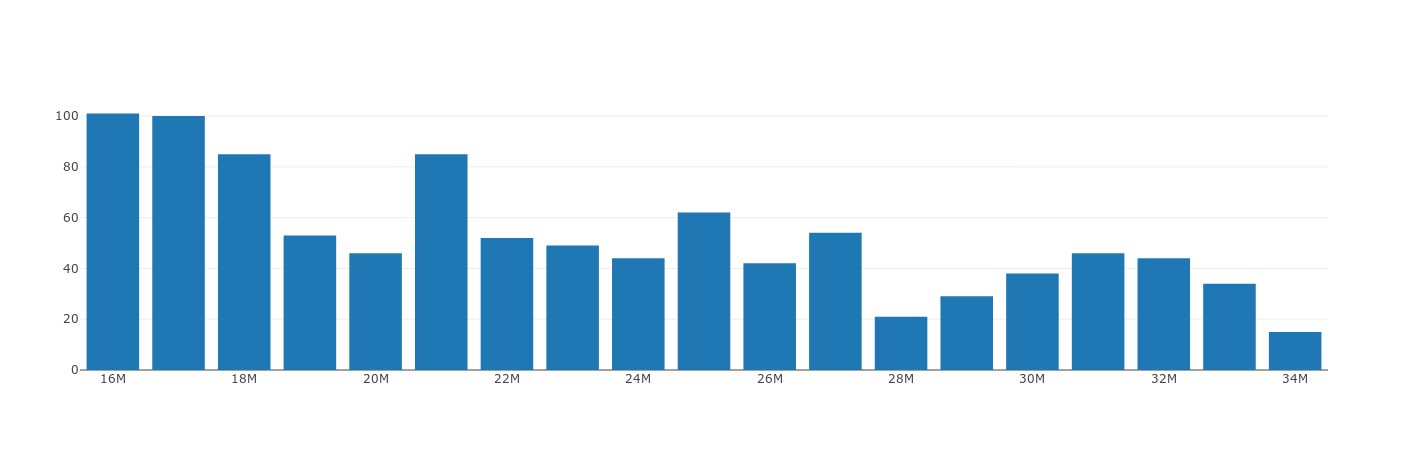

In [13]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

pandasHistogramDF = oskar.histogram(df,"start",1000000).toPandas()

init_notebook_mode(connected = True)

data = [go.Bar(x= pandasHistogramDF["start"], y = pandasHistogramDF["count"])]
py.iplot(data)

** If you are using jupyter lab you will need to download this extension https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension to visualize the plot*